In [16]:
import torch, torchvision
print(torchvision.__version__, torch.cuda.is_available())

0.20.1 False


In [17]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# detectron2 utilities
from detectron2 import model_zoo
from detectron2 .config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer, ColorMode

# Other libraries
import cv2 # OpenCV
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
from pathlib import Path

In [18]:
# base directory to data
base_path_data = Path('Input/Data')

# base directory for images
base_path_image = base_path_data.joinpath('images')

# background image directory
back_path = base_path_image.joinpath('background')

# foreground image directory
fore_path = base_path_image.joinpath('foreground')

# output file directory
output_path = base_path_image.joinpath('output')

# test image directory
test_path = base_path_image.joinpath('test')
test_path.mkdir(parents=True, exist_ok=True)

# train directory containing all the training images
train_path = base_path_image.joinpath('train')
train_path.mkdir(parents=True, exist_ok=True)

# annotation directory for annotated data
annot_path = base_path_data.joinpath('annotations')
annot_path.mkdir(parents=True, exist_ok=True)

In [19]:
register_name = 'detection_segmentaion'
annotation = str(annot_path.joinpath('annotations.json'))
train =  str(train_path)
register_coco_instances(register_name, 
                        {}, 
                        annotation, 
                        train)

In [20]:
# MetadataCatalog is a key-value mapping which contains names of classes, colors of classes, root of files, etc. 
bio_train_metadata = MetadataCatalog.get(register_name)

# A global dictionary which contains information about the datasets.
# It also makes it easier to choose different datasets, by just using the strings in the config.
dataset_dicts_train = DatasetCatalog.get(register_name)

WARNING [06/04 21:16:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/04 21:16:23 d2.data.datasets.coco]: Loaded 52 images in COCO format from Input/Data/annotations/annotations.json


In [21]:
print(dataset_dicts_train)


[{'file_name': 'Input/Data/images/train/synthetic_antibiogram_2.jpg', 'height': 754, 'width': 980, 'image_id': 1, 'annotations': [{'iscrowd': 0, 'bbox': [332.8, 549.1, 181.93333333333334, 156.84285714285716], 'category_id': 1, 'segmentation': [[484.0, 705.2, 501.2, 677.0, 507.2, 663.0, 508.6, 656.0, 514.2, 648.0, 514.7333333333333, 643.0, 514.2, 627.0, 503.2, 611.0, 504.2, 599.0, 509.2, 593.0, 511.2, 587.0, 509.2, 583.0, 505.0, 579.8, 502.0, 579.8, 496.0, 586.8, 494.2, 585.0, 495.2, 575.0, 498.2, 570.0, 497.2, 564.0, 493.0, 559.8, 491.0, 559.8, 479.0, 572.8, 476.2, 570.0, 477.2, 555.0, 474.0, 550.8, 466.0, 549.4, 458.0, 556.8, 456.0, 556.8, 449.0, 549.8, 442.0, 549.1, 436.0, 550.8, 429.0, 557.8, 423.0, 555.8, 420.0, 556.8, 415.0, 551.8, 410.0, 551.8, 402.0, 556.8, 395.0, 556.8, 384.0, 559.8, 375.0, 565.8, 350.8, 589.0, 335.8, 626.0, 334.8, 635.0, 332.8, 638.0, 334.8, 645.0, 334.8, 660.0, 337.8, 665.0, 339.8, 674.0, 348.8, 692.0, 353.0, 696.2, 360.0, 698.2, 363.8, 704.0, 367.0, 705.9428

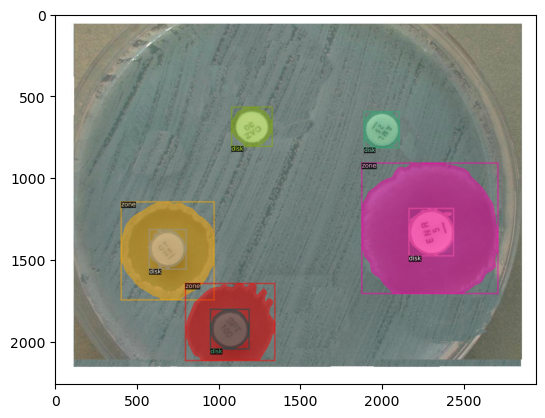

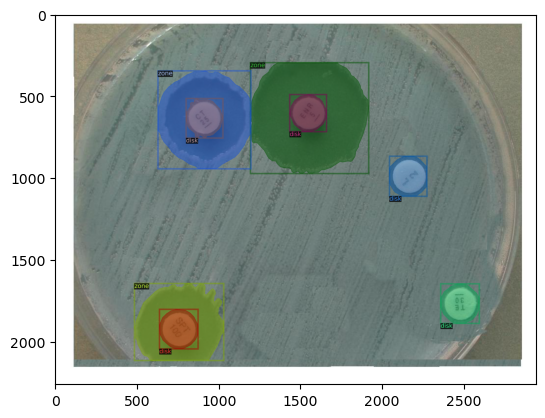

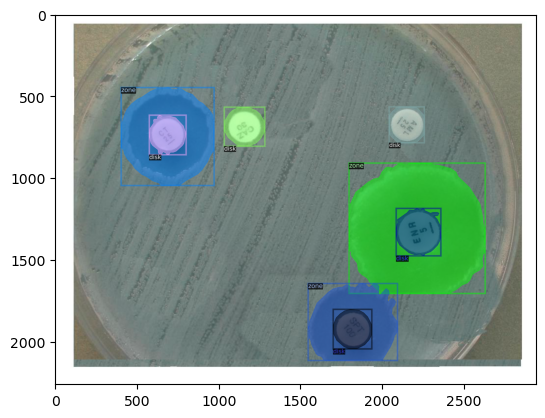

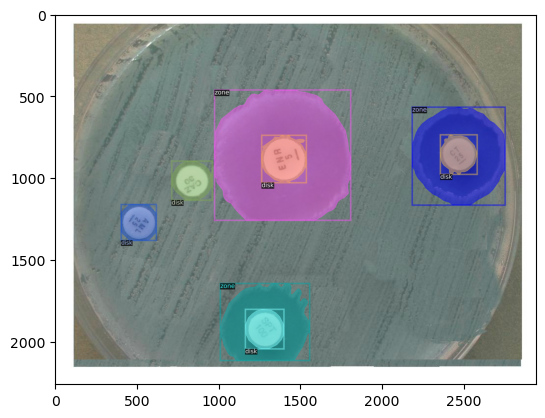

In [22]:
for d in random.sample(dataset_dicts_train, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=bio_train_metadata, scale=3)
    vis = visualizer.draw_dataset_dict(d)
    #cv2.imshow('test',vis.get_image()[:, :, ::-1])
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [23]:
# COCOEvaluator enables evaluation of:
# AP (Average Precision) for box detection, instance segmentation, keypoint detection on any custom dataset,
#  using dataset's official API.

class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [24]:
cfg = get_cfg() 

cfg.MODEL.DEVICE='cpu'
# Load values from a file
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Add new configs custom components
cfg.DATASETS.TRAIN = (register_name,) # training images; remember to add ",", dtype: tuple
cfg.DATASETS.TEST = () # validation images; remember to add ",", dtype: tuple
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # initialize from model zoo
#cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2 # images per batch
cfg.SOLVER.BASE_LR = 0.0001 # mininum learning rate

cfg.SOLVER.WARMUP_ITERS = 10
cfg.SOLVER.MAX_ITER = 100


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  

cfg.TEST.EVAL_PERIOD = 10

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False) 
trainer.train() # Training

[06/04 21:16:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[06/04 21:16:29 d2.engine.train_loop]: Starting training from iteration 0
[06/04 21:17:59 d2.utils.events]:  eta: 0:06:06  iter: 19  total_loss: 2.699  loss_cls: 0.9375  loss_box_reg: 0.929  loss_mask: 0.6653  loss_rpn_cls: 0.01184  loss_rpn_loc: 0.03089    time: 4.4130  last_time: 4.6573  data_time: 0.0908  last_data_time: 0.0008   lr: 0.0001  
[06/04 21:19:24 d2.utils.events]:  eta: 0:04:29  iter: 39  total_loss: 1.95  loss_cls: 0.5363  loss_box_reg: 0.8969  loss_mask: 0.5001  loss_rpn_cls: 0.001512  loss_rpn_loc: 0.0162    time: 4.3283  last_time: 4.6376  data_time: 0.0010  last_data_time: 0.0011   lr: 0.0001  
[06/04 21:20:48 d2.utils.events]:  eta: 0:02:49  iter: 59  total_loss: 1.638  loss_cls: 0.4148  loss_box_reg: 0.8402  loss_mask: 0.3854  loss_rpn_cls: 0.001329  loss_rpn_loc: 0.0136    time: 4.2850  last_time: 3.7870  data_time: 0.0011  last_data_time: 0.0011   lr: 0.0001  
[06/04 21:22:15 d2.utils.events]:  eta: 0:01:25  iter: 79  total_loss: 1.401  loss_cls: 0.3067  loss_bo

In [ ]:
# inference code

[06/04 21:30:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/opt/anaconda3/envs/detectron2-env/lib/python3.9/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_locati

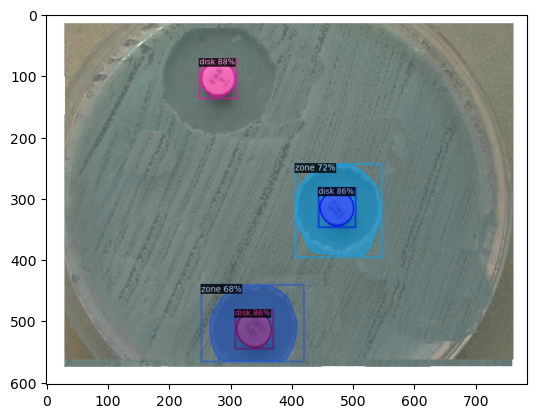

In [45]:
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances

register_name = "detection_segmentaion"
annotation = "Input/Data/annotations/annotations.json"
image_root = "Input/Data/images/train"

register_coco_instances(register_name, {}, annotation, image_root)

# Set your class names here
MetadataCatalog.get(register_name).thing_classes = ["disk", "zone"]
metadata = MetadataCatalog.get(register_name)

# Now your cfg
cfg = get_cfg()
cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.STEPS = (1000, 1500)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 164
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.TEST.EVAL_PERIOD = 100

# Point to your trained weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6

predictor = DefaultPredictor(cfg)
im = cv2.imread(str(inference_image_2))
outputs_inference_image_2 = predictor(im)

metadata = MetadataCatalog.get(register_name)
v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8)
out = v.draw_instance_predictions(outputs_inference_image_2["instances"].to("cpu"))
out.save('./test_image_1_inference.jpg')

plt.imshow(out.get_image()[:, :, ::-1])
plt.show()


In [25]:
cfg = get_cfg() 

cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = (register_name,) # training images; remember to add ",", dtype: tuple
# cfg.DATASETS.TEST = () # validation images; remember to add ",", dtype: tuple
cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 2 # images per batch
cfg.SOLVER.BASE_LR = 0.02 # mininum learning rate
cfg.SOLVER.WARMUP_ITERS = 1000 
cfg.SOLVER.MAX_ITER = 2000    
cfg.SOLVER.STEPS = (1000, 1500) 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 164 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 1 classe (rot)
cfg.TEST.EVAL_PERIOD = 100 

In [26]:
cfg.OUTPUT_DIR

'./output'

In [46]:
outputs_inference_image_2['instances']

Instances(num_instances=5, image_height=754, image_width=980, fields=[pred_boxes: Boxes(tensor([[312.5238,  91.3227, 387.9115, 171.5081],
        [384.7771, 602.8447, 462.2898, 681.7224],
        [555.5834, 354.1166, 630.1335, 433.6110],
        [507.2446, 305.2226, 683.1964, 495.1395],
        [316.2937, 551.9497, 524.6454, 707.7101]])), scores: tensor([0.8812, 0.8626, 0.8565, 0.7212, 0.6849]), pred_classes: tensor([0, 0, 0, 1, 1]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
   

In [47]:
outputs_inference_image_2['instances'].pred_classes

tensor([0, 0, 0, 1, 1])

In [48]:
outputs_inference_image_2['instances'].pred_boxes

Boxes(tensor([[312.5238,  91.3227, 387.9115, 171.5081],
        [384.7771, 602.8447, 462.2898, 681.7224],
        [555.5834, 354.1166, 630.1335, 433.6110],
        [507.2446, 305.2226, 683.1964, 495.1395],
        [316.2937, 551.9497, 524.6454, 707.7101]]))

In [49]:
outputs_inference_image_2['instances'].scores

tensor([0.8812, 0.8626, 0.8565, 0.7212, 0.6849])

In [50]:
outputs_inference_image_2['instances'].pred_masks[0]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [51]:
def _create_text_labels(classes, scores, class_names, is_crowd=None):
    labels = None
    if classes is not None:
        if class_names is not None and len(class_names) > 0:
            labels = [class_names[i] for i in classes]
        else:
            labels = [str(i) for i in classes]
    if scores is not None:
        if labels is None:
            labels = ["{:.0f}%".format(s * 100) for s in scores]
        else:
            labels = ["{} {:.0f}%".format(l, s * 100) for l, s in zip(labels, scores)]
    if labels is not None and is_crowd is not None:
        labels = [l + ("|crowd" if crowd else "") for l, crowd in zip(labels, is_crowd)]
    return labels


In [52]:
predictions = outputs_inference_image_2["instances"].to("cpu")

boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
scores = predictions.scores if predictions.has("scores") else None
classes = predictions.pred_classes.tolist() if predictions.has("pred_classes") else None
labels = _create_text_labels(classes, scores, ['wound', 'marker'])
keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

masks_list = list()
if predictions.has("pred_masks"):
    masks = np.asarray(predictions.pred_masks)
    for mask in masks:
        mask = 255 * mask
        masks_list.append(mask)
else:
    masks = None

In [53]:
all_bboxes=boxes.tensor.cpu().numpy()

In [54]:
all_bboxes[0]

array([312.5238 ,  91.32272, 387.91153, 171.5081 ], dtype=float32)

In [55]:
x0w, y0w, x1w, y1w = all_bboxes[0]
wound_cropped = im[int(y0w):int(y1w), int(x0w):int(x1w)]
cv2.imwrite("bbox_cropped.jpg", wound_cropped)

True

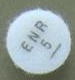

In [56]:
from IPython.display import Image
Image(filename='bbox_cropped.jpg') 

In [57]:
# masking plot

In [58]:
def mask_updated(image_img, mask_img):

    img_grayscale = cv2.cvtColor(image_img, cv2.COLOR_BGR2GRAY)
    img_grayscale = cv2.merge([img_grayscale, img_grayscale, img_grayscale])

    mask_img = cv2.merge([mask_img, mask_img, mask_img])
    cv2.imwrite("masked.jpg", mask_img)
    mask_img = cv2.imread("masked.jpg")

    bitwise = cv2.bitwise_or(img_grayscale, mask_img)

    mask_img = ~mask_img
    cv2.imwrite("mask_image_here.jpg", mask_img)

    bitwise_wound = cv2.bitwise_or(image_img, mask_img)
    bitwise_wound_filepath = "bitwise_wound_filepath.jpg"
    cv2.imwrite(bitwise_wound_filepath, bitwise_wound)

    bitwise_and = cv2.bitwise_and(bitwise, bitwise_wound)
    filepath ="masked_image.jpg"
    cv2.imwrite(filepath, bitwise_and)

In [59]:
mask_updated(im,masks_list[3])

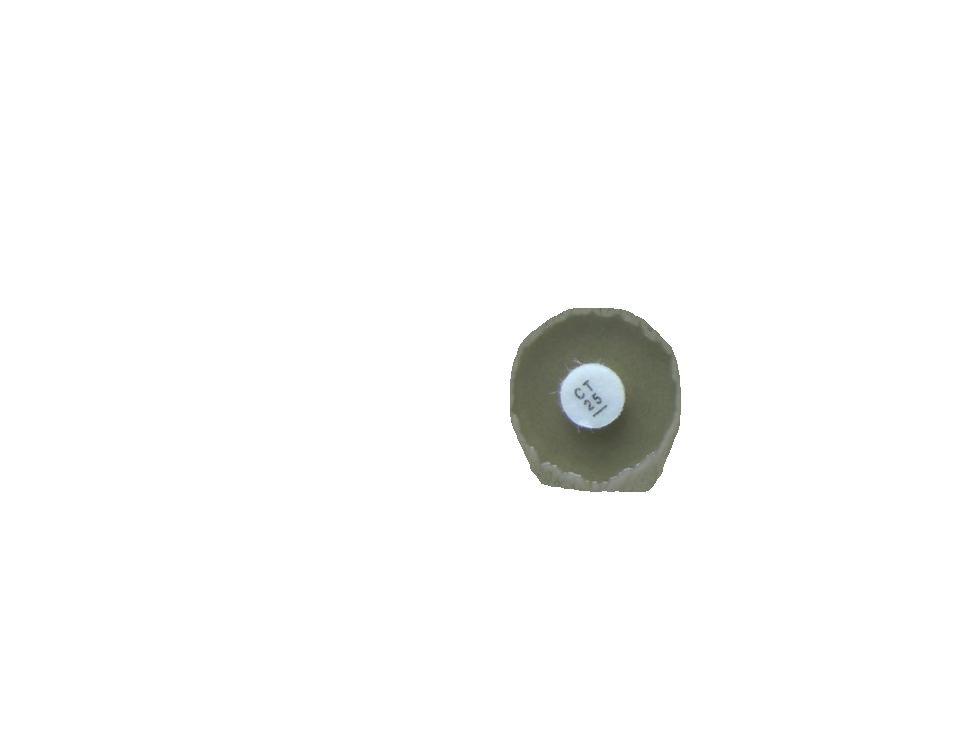

In [60]:
Image(filename='bitwise_wound_filepath.jpg') 